In [83]:
import numpy as np
from ptsa.data.readers import EEGReader,TalReader
from ptsa.data.filters import MorletWaveletFilterCpp,MonopolarToBipolarMapper, MorletWaveletFilter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from ptsa.data.TimeSeriesX import TimeSeriesX
import pandas as pd
from scipy.stats import zscore,ttest_rel, ttest_ind
%matplotlib inline 
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,roc_curve, auc
from cluster_helper import cluster
from sklearn.externals import joblib
import xarray
from scipy import interp
import pprint


In [65]:
#runs on specific C paramter, defaulted as 1.0
def get_vault3(regular, vault, c=1.0):
    
    for session in np.unique(regular.events.values['session']):
            regular[regular.events.values['session']==session] = zscore(
                        regular[regular.events.values['session']==session],
                                                                     axis=0)
    
    
    vaultZ = (vault - vault.mean('events'))/vault.std('events')
    #logistic regression
    lr = LogisticRegression(penalty='l2', C=c)
    lrFit = lr.fit(regular, regular.events.values['recalled'])
    vault_predictions = lrFit.predict_proba(vaultZ)[:, 1]
    vault_actuals = vaultZ.events.values['recalled']
    return [vault_predictions, vault_actuals]

In [51]:
regularZ

NameError: name 'regularZ' is not defined

In [59]:
#takes in number of session to leave out, runs on specific C paramter, defaulted as 1.0
def loso3(numS, features, c=1.0):
    
    #regular = sessions not left out
    regular = features.sel(events=features.events.values['session'] != numS)
    for session in np.unique(regular.events.values['session']):
            regular[regular.events.values['session']==session] = zscore(
                        regular[regular.events.values['session']==session],
                                                                     axis=0)

#     print(regularZ)
    
    #session left out
    left_out = features.sel(events=features.events.values['session']==numS)
    left_outZ = (left_out - left_out.mean('events'))/left_out.std('events')
    
    
    #logistic regression
    lr = LogisticRegression(penalty='l2', C=c)
    lrFit = lr.fit(regular, regular.events.values['recalled'])
    test_probs = lrFit.predict_proba(left_outZ)[:, 1]
    actual_labels = left_outZ.events.values['recalled']
    return [test_probs, actual_labels]

In [ ]:
# def get_probs_actual_loso3(feat_array):
    
#     probs = np.empty(len(feat_array))
#     probs.fill(np.nan)
#     actual = np.empty(len(feat_array))
#     actual.fill(np.nan)
    
    
    
#     for ss in np.unique(feat_array.events.values['session']):
#         print(str(ss) + "/" + str(len(np.unique(feat_array.events.values['session']))))
#         loso_result = loso(ss,feat_array)
#         probs[feat_array.events.values['session']==ss] = loso_result[0]
#         actual[feat_array.events.values['session']==ss] = loso_result[1]
#     return [probs,actual]


In [37]:
# feat_array should NOT include the vault
def get_vals_one_c(feat_array,c):
    ss = np.max(feat_array.events.values['session'])
    loso_result = loso3(ss, feat_array, c)
    probs = loso_result[0]
    actual = loso_result[1]
    return [probs, actual]

In [11]:
def getAUC(rocX, rocY):
    return np.trapz(rocY, x=rocX)

In [57]:
subs=  ['R1051J', 'R1060M', 'R1065J', 'R1137E', 'R1154D', 'R1161E','R1189M', 'R1195E', 'R1236J']
ch = 'bipolar_pairs'
# subs=  ['LTP123', 'LTP133', 'LTP249', 'LTP258', 'LTP330', 'LTP115', 'LTP138', 'LTP265', 'LTP283',
# 'LTP93', 'LTP259', 'LTP285', 'LTP304']

c_vals = np.logspace(np.log10(1e-6),np.log10(1e4), num = 10)

aucs_by_c = {}
for c in c_vals:
    aucs_by_c[c] = []

# aucs_loso = {}
# aucs_vault = {}


for subjectID in subs:
    print(subjectID)
    data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/iEEG_Power_Files/%s.hdf5' % (subjectID))
    #data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/LTP123.hdf5')
    
    features = np.log10(data.stack(features=('frequency',ch)))
    
    lastSession = np.max(np.unique(features.events.values['session']))
    vault = features.sel(events=features.events.values['session']==lastSession)
    remaining = features.sel(events=features.events.values['session']!=lastSession)
    
    for c in c_vals:
        data_remaining = get_vals_one_c(remaining,c)
        probs_remaining = data_remaining[0]
        actual_remaining = data_remaining[1]
#         fprs,tprs,thresholds = roc_curve(actual_remaining, probs_remaining)
#         aucs_by_c[c].append(auc(fprs,tprs))
        aucs_by_c[c].append(roc_auc_score(actual_remaining,probs_remaining))
    
#     print("Now doing the vault")
#     data_vault = get_vault(remaining,vault)
#     probs_vault = data_vault[0]
#     actual_vault = data_vault[1]
    
#     print("Got the vault")
    

#     aucs_loso[subjectID] = format(auc(fprs,tprs),'.3f')
#     tpr_lolo = interp(base_fpr, fprs, tprs)
#     tpr_lolo[0] = 0.0
#     tprs_lolo.append(tpr_lolo)
    

#     fprs2,tprs2,thresholds = roc_curve(actual_vault, probs_vault)
# #     myROC_LOSO = getROC(thresholds,actual_vault,probs_vault,1)
# #     fprs2 = myROC_LOSO[0]
# #     tprs2 = myROC_LOSO[1]
#     aucs_vault[subjectID] = format(auc(fprs2,tprs2),'.3f')
#     tpr_loso = interp(base_fpr, fprs2, tprs2)
#     tpr_loso[0] = 0.0
#     tprs_loso.append(tpr_loso)

# plotROCAvg("ROC (Average Across Subjects)",base_fpr, tprs_lolo, tprs_loso,
#       None)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(aucs_by_c)
# pp.pprint(aucs_vault)

R1051J
<xarray.TimeSeriesX (events: 300, features: 413)>
array([[ 0.557757,  0.385633, -1.514685, ...,  2.302626, -0.23919 ,  2.406522],
       [ 2.088108,  2.171752,  0.446788, ...,  0.548203,  0.66467 ,  2.044703],
       [-0.729753, -0.881399, -0.164636, ..., -0.384697, -0.421316,  0.551696],
       ..., 
       [ 0.226572, -0.333393, -0.451421, ...,  0.8755  , -0.699242, -1.588339],
       [-0.640458, -0.945855, -0.574758, ...,  1.803556, -0.410099,  0.292849],
       [-0.098395, -0.520752,  0.077006, ...,  0.792721,  1.400374,  1.211358]])
Coordinates:
    samplerate     float64 2e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1051J', 0, 1, 1, 'WORD', 'MUG', 162, 0,   1.43662838e+12, 1, -999, -999, '/data/eeg/R1

<xarray.TimeSeriesX (events: 300, features: 413)>
array([[ 0.557757,  0.385633, -1.514685, ...,  2.302626, -0.23919 ,  2.406522],
       [ 2.088108,  2.171752,  0.446788, ...,  0.548203,  0.66467 ,  2.044703],
       [-0.729753, -0.881399, -0.164636, ..., -0.384697, -0.421316,  0.551696],
       ..., 
       [ 0.226572, -0.333393, -0.451421, ...,  0.8755  , -0.699242, -1.588339],
       [-0.640458, -0.945855, -0.574758, ...,  1.803556, -0.410099,  0.292849],
       [-0.098395, -0.520752,  0.077006, ...,  0.792721,  1.400374,  1.211358]])
Coordinates:
    samplerate     float64 2e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1051J', 0, 1, 1, 'WORD', 'MUG', 162, 0,   1.43662838e+12, 1, -999, -999, '/data/eeg/R1051J/ee

<xarray.TimeSeriesX (events: 600, features: 616)>
array([[-0.542634,  0.083794, -0.419669, ...,  0.247723,  0.008166,  0.795085],
       [ 1.360525,  0.090728, -0.580778, ..., -1.926361,  0.267569, -0.320578],
       [ 1.034595,  1.82819 ,  0.986977, ..., -1.218192,  0.283189,  0.909625],
       ..., 
       [ 0.364579,  0.279728,  0.372773, ...,  0.374243,  0.156588,  0.102249],
       [ 0.280382,  0.456569,  0.122639, ...,  0.480427,  0.054588,  0.159818],
       [-0.911783, -0.241474,  1.241107, ...,  0.534445, -0.147485,  0.044974]])
Coordinates:
    samplerate     float64 499.7
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1060M', 0, 1, 1, 'WORD', 'DUCK', 82, 1,   1.43783455e+12, 1, 3270, -999, '/data/eeg/R1060M/ee

<xarray.TimeSeriesX (events: 1200, features: 1211)>
array([[ 0.991687,  0.054088,  0.762619, ...,  1.495261,  1.175613,  0.548795],
       [-1.088191, -0.886697, -0.43097 , ..., -0.763462, -0.038021, -0.718724],
       [-0.9206  , -0.038383, -0.413247, ..., -0.468765, -0.194751, -0.793791],
       ..., 
       [ 0.880469,  0.068937,  0.343874, ..., -1.616348, -0.596095, -1.746334],
       [ 0.802484,  0.574585, -0.062012, ...,  0.386006,  0.736828,  0.200482],
       [-0.919682, -1.198877, -1.107614, ...,  0.964327,  0.41789 ,  0.902232]])
Coordinates:
    samplerate     float64 1e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1065J', 0, 1, 1, 'WORD', 'SEAT', 213, 1,   1.43785523e+12, 1, 8090, -999, '/data/eeg/R1065J

R1137E
<xarray.TimeSeriesX (events: 288, features: 497)>
array([[-0.342876, -0.381005,  0.252069, ..., -1.77861 ,  0.082058,  0.56065 ],
       [ 1.366672, -0.129039,  0.669149, ...,  0.676122,  0.425977, -0.765602],
       [ 0.866327,  0.42983 ,  0.236211, ...,  0.181142,  0.105923,  1.128985],
       ..., 
       [-1.209912, -0.143261,  0.511788, ...,  0.730523,  0.481974, -1.085837],
       [ 0.593427,  0.814381,  0.69908 , ..., -0.692063, -0.053305, -0.781928],
       [ 0.987129,  0.36908 ,  1.778404, ...,  1.372078,  1.266513, -0.088397]])
Coordinates:
    samplerate     float64 499.7
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1137E', 0, 2, 1, 'WORD', 'INK', 132, 1,   1.45349843e+12, 1, 2634, -999, '/data/eeg/R1

<xarray.TimeSeriesX (events: 288, features: 497)>
array([[-0.342876, -0.381005,  0.252069, ..., -1.77861 ,  0.082058,  0.56065 ],
       [ 1.366672, -0.129039,  0.669149, ...,  0.676122,  0.425977, -0.765602],
       [ 0.866327,  0.42983 ,  0.236211, ...,  0.181142,  0.105923,  1.128985],
       ..., 
       [-1.209912, -0.143261,  0.511788, ...,  0.730523,  0.481974, -1.085837],
       [ 0.593427,  0.814381,  0.69908 , ..., -0.692063, -0.053305, -0.781928],
       [ 0.987129,  0.36908 ,  1.778404, ...,  1.372078,  1.266513, -0.088397]])
Coordinates:
    samplerate     float64 499.7
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1137E', 0, 2, 1, 'WORD', 'INK', 132, 1,   1.45349843e+12, 1, 2634, -999, '/data/eeg/R1137E/ee

<xarray.TimeSeriesX (events: 300, features: 770)>
array([[ 1.834477,  1.829503,  0.640298, ...,  0.525277,  0.145637, -1.883638],
       [-1.155175, -0.26681 , -0.427762, ...,  1.033731, -0.083047, -0.044586],
       [-1.582768, -1.79534 ,  0.858604, ...,  0.041745,  1.125317, -1.010318],
       ..., 
       [-0.087447, -0.456756,  0.671442, ..., -0.043591,  0.362215, -0.059142],
       [-0.951986, -0.335304, -0.106383, ...,  1.205184, -0.310931,  0.262447],
       [ 1.20111 ,  0.867702, -1.496915, ...,  0.110008, -2.413205, -1.316502]])
Coordinates:
    samplerate     float64 1e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1154D', 0, 1, 1, 'WORD', 'SHRIMP', 223, 1,   1.46290361e+12, 1, 18276, -999, '/data/eeg/R1154

<xarray.TimeSeriesX (events: 300, features: 434)>
array([[-0.974993, -0.945991, -1.506674, ..., -1.110911, -0.942855, -1.202277],
       [ 0.505271,  0.336566, -0.443309, ..., -0.514998, -0.414925,  1.347582],
       [ 0.583036,  0.595589,  0.211466, ...,  0.360992,  0.398007, -1.458931],
       ..., 
       [ 0.827351,  0.334785,  1.753489, ..., -0.920084, -0.722267,  0.953037],
       [ 0.189115, -0.852926,  1.067364, ...,  0.12009 ,  0.095531,  0.498707],
       [ 0.326168, -0.738215, -0.425615, ..., -0.59243 , -0.648463,  1.082355]])
Coordinates:
    samplerate     float64 1e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1161E', 0, 1, 1, 'WORD', 'SIGN', 224, 0,   1.46023185e+12, 1, -999, -999, '/data/eeg/R1161E/e

<xarray.TimeSeriesX (events: 300, features: 756)>
array([[ 1.516686,  1.312057, -0.855942, ...,  0.60819 ,  1.109057,  1.234986],
       [ 1.019563,  0.924243,  0.083012, ...,  1.508622,  1.370894, -0.379088],
       [ 0.519378,  0.516838, -1.761955, ...,  0.07432 , -0.854721,  0.675601],
       ..., 
       [-1.511069, -2.273946, -0.948408, ..., -0.666119,  0.104671, -0.432402],
       [-2.402629, -2.24316 , -1.801362, ..., -0.011486,  0.964112, -0.589748],
       [ 1.443454,  1.256287, -1.133534, ..., -0.088832,  0.15683 ,  3.100388]])
Coordinates:
    samplerate     float64 1e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1189M', 0, 1, 1, 'WORD', 'MOON', 156, 1,   1.46954720e+12, 1, 2873, -999, '/data/eeg/R1189M/e

<xarray.TimeSeriesX (events: 300, features: 784)>
array([[-2.840587, -0.320168,  0.56928 , ...,  1.068295,  0.490754,  0.894481],
       [-0.275712, -0.005821,  0.107314, ...,  1.068974,  0.359093, -0.897264],
       [-1.985726, -1.523811, -1.643098, ...,  0.766298,  0.466551,  0.163749],
       ..., 
       [ 2.006043,  1.4322  ,  0.296904, ..., -1.267732, -0.351287,  0.723877],
       [ 0.354618,  0.993403,  0.670329, ..., -0.120972,  0.018584,  0.954234],
       [-0.524546,  0.982789,  0.428792, ...,  0.211494,  0.671936,  1.614872]])
Coordinates:
    samplerate     float64 1e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1195E', 0, 1, 1, 'WORD', 'PALM', 171, 1,   1.46775706e+12, 1, 22330, -999, '/data/eeg/R1195E/

<xarray.TimeSeriesX (events: 600, features: 1169)>
array([[-1.750936, -1.815285, -2.10779 , ..., -0.352268, -1.297708,  0.046813],
       [-0.402747, -0.162923, -1.694475, ...,  0.808454,  1.322543,  0.397652],
       [-0.010438, -0.346207, -0.997637, ...,  1.570549, -0.756107,  1.544653],
       ..., 
       [-0.129658,  0.349174, -0.997176, ..., -0.648897,  0.662968,  0.015473],
       [-0.492158,  0.098293, -1.524328, ..., -0.291669,  1.330586, -0.597288],
       [ 1.80857 ,  2.120909,  1.111259, ..., -0.05047 ,  0.907477,  1.50569 ]])
Coordinates:
    samplerate     float64 1e+03
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')] ('R1236J', 0, 1, 1, 'WORD', 'SALT', 209, 1,   1.47759706e+12, 1, 1203, -999, '/data/eeg/R1236J/

{   9.9999999999999995e-07: [   0.56368421052631579,
                                0.45626373626373629,
                                0.68093892632036512,
                                0.48843981130976649,
                                0.65388695987654322,
                                0.54945154977015154,
                                0.484415917843389,
                                0.64926136363636366,
                                0.62687044038553696],
    1.2915496650148827e-05: [   0.5633971291866029,
                                0.44654456654456653,
                                0.68311236687676602,
                                0.48948809038495139,
                                0.6547550154320988,
                                0.55036184060807425,
                                0.48498074454428758,
                                0.64880681818181818,
                                0.62676393844187661],
    0.00016681005372000591: [   0.56392344497607

In [44]:
c_vals

array([  1.00000000e-06,   1.29154967e-05,   1.66810054e-04,
         2.15443469e-03,   2.78255940e-02,   3.59381366e-01,
         4.64158883e+00,   5.99484250e+01,   7.74263683e+02,
         1.00000000e+04])

Best C is 0.00016681005372
Best AUC is 0.574704190568


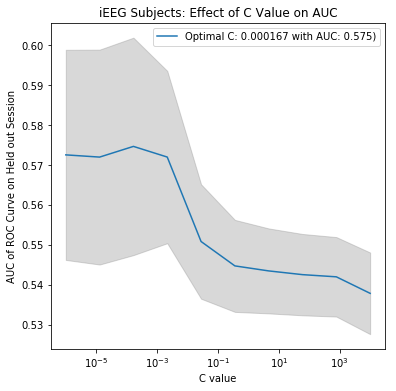

In [81]:
# c_vals = np.logspace(np.log10(1e-6),np.log10(1e4), num = 10)
avgs = np.zeros(len(c_vals))
stes = np.zeros(len(c_vals))

count = 0
best = 0
bestC = c_vals[0]

for c in c_vals:
    vals = aucs_by_c[c] #all subjects, one c
    avgs[count] = np.mean(vals) #mean auc value
    stes[count] = np.std(vals)/np.sqrt(len(vals))
    if (avgs[count]>best):
        best = avgs[count]
        bestC = c
    count += 1
print('Best C is ' + str(bestC))
print('Best AUC is ' + str(best))

fig, ax = plt.subplots(1,1, figsize=(6,6))
plt.fill_between(c_vals, avgs-stes, avgs+stes, color= 'grey', alpha = 0.3)
ax.semilogx(c_vals, avgs,label='Optimal C: %.6f with AUC: %.3f)' % (bestC,best))
plt.title('iEEG Subjects: Effect of C Value on AUC')
ax.set_xlabel('C value')
ax.set_ylabel('AUC of ROC Curve on Held out Session')
ax.legend()
plt.savefig('/data/home/jonlevi/ML_Project/figs/iEEG_CCurve')

In [82]:
def plotOptimal(title, base_fpr, tprs, filename=None): 
    avg_tprs = np.mean(tprs, axis=0)
    ste_tprs = np.std(tprs,axis=0) / np.sqrt(np.shape(tprs)[0])
    lower = avg_tprs - ste_tprs
    upper = np.minimum(avg_tprs + ste_tprs,1)
    
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    plt.title(title)
    
    
    plt.fill_between(base_fpr, lower, upper, color= 'grey', alpha = 0.3)
    plt.plot(base_fpr,avg_tprs,label='AUC: %.3f' % (auc(base_fpr,avg_tprs)))
    
    ax.legend(loc='best')
    ax.plot([0,1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    if filename:
        plt.savefig("%s.jpg" % (filename), bbox_inches='tight')

    plt.show()

# RUN FOR OPTIMAL C VALUE

R1051J
R1060M
R1065J
R1137E
R1154D
R1161E
R1189M
R1195E
R1236J
{   'R1051J': '0.561',
    'R1060M': '0.602',
    'R1065J': '0.623',
    'R1137E': '0.674',
    'R1154D': '0.580',
    'R1161E': '0.583',
    'R1189M': '0.543',
    'R1195E': '0.594',
    'R1236J': '0.692'}


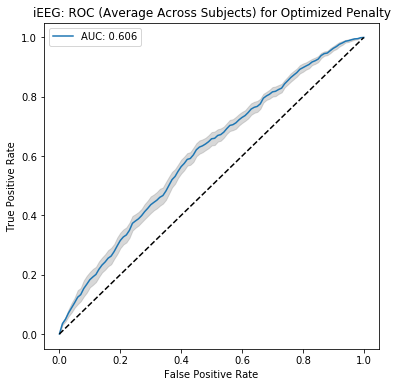

In [78]:
#subs is list of subjects
#ch is string: either bipolar_pairs or channels
def optimalROC(subs, ch)
    c = bestC
    tprs_all = []
    aucs_vault = {}
    base_fpr = np.linspace(0, 1, 101)


    for subjectID in subs:
        print(subjectID)
        
        #CHANGE PATH TO FIT: SORRY FOR NOT MAKING IT MODULAR
        
        data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/iEEG_Power_Files/%s.hdf5' % (subjectID))

        features = np.log10(data.stack(features=('frequency',ch)))

        lastSession = np.max(np.unique(features.events.values['session']))
        vault = features.sel(events=features.events.values['session']==lastSession)
        remaining = features.sel(events=features.events.values['session']!=lastSession)


        data_vault = get_vault3(remaining,vault,c)
        probs_vault = data_vault[0]
        actual_vault = data_vault[1]
        
        fprs,tprs,thresholds = roc_curve(actual_vault, probs_vault)
        aucs_vault[subjectID] = format(roc_auc_score(actual_vault,probs_vault),'.3f')
        tpr_vault = interp(base_fpr, fprs, tprs)
        tpr_vault[0] = 0.0
        tprs_all.append(tpr_vault)


    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(aucs_vault)

    plotOptimal("iEEG: ROC (Average Across Subjects) for Optimized Penalty",
               base_fpr,tprs_all,'/data/home/jonlevi/ML_Project/figs/iEEG_ROC_optim')

In [ ]:
subs = LTPsubs
optimalROC(subs, 'channels')

# Part 4

In [147]:
def removeFeatures(data,ch):
    data2 = data[data['frequency'] == 80.0]
    dataT = data2.transpose('events',ch,'frequency')
    stats,_ = ttest_ind(dataT[dataT.events.values['recalled']==1.0],
                    dataT[dataT.events.values['recalled']==0.0],
                    axis=0)
    sortedStats = np.argsort(stats,axis=0)
    chansToUse = sortedStats[0:int(len(sortedStats)/2)]
    chansToUse = np.squeeze(chansToUse)
    return chansToUse
    

In [160]:

#subs is list of subjects
#ch is string: either bipolar_pairs or channels
#c is optimal C
def part4ROC(subs, ch, c):
    c = bestC

    aucs_vault = {}


    for subjectID in subs:
        print(subjectID)
        
        #CHANGE PATH TO FIT: SORRY FOR NOT MAKING IT MODULAR
        data = TimeSeriesX.from_hdf('/data/home/jonlevi/ML_Project/iEEG_Power_Files/%s.hdf5' % (subjectID))
        
        chansToUse = removeFeatures(data,ch)
        dataChanged = data[:,chansToUse,:]

        features = np.log10(dataChanged.stack(features=('frequency',ch)))

        lastSession = np.max(np.unique(features.events.values['session']))
        vault = features.sel(events=features.events.values['session']==lastSession)
        remaining = features.sel(events=features.events.values['session']!=lastSession)


        data_vault = get_vault3(remaining,vault,c)
        probs_vault = data_vault[0]
        actual_vault = data_vault[1]
        
        #fprs,tprs,thresholds = roc_curve(actual_vault, probs_vault)
        aucs_vault[subjectID] = format(roc_auc_score(actual_vault,probs_vault),'.3f')
        


    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(aucs_vault)







In [161]:
bestC = 0.00016681005372000591
part4ROC(subs,'bipolar_pairs',bestC)

R1051J
R1060M
R1065J
R1137E
R1154D
R1161E
R1189M
R1195E
R1236J
{   'R1051J': '0.561',
    'R1060M': '0.578',
    'R1065J': '0.539',
    'R1137E': '0.618',
    'R1154D': '0.551',
    'R1161E': '0.575',
    'R1189M': '0.544',
    'R1195E': '0.556',
    'R1236J': '0.666'}


In [152]:
bestC

0.00016681005372000591

In [145]:
features3 = features2[:,chansToUse,:]

In [146]:
features3

<xarray.TimeSeriesX (events: 1200, bipolar_pairs: 83, frequency: 1)>
array([[[  66812.808755],
        [  22995.67812 ],
        ..., 
        [  24552.432338],
        [  65223.626271]],

       [[  69585.889633],
        [  28448.845349],
        ..., 
        [  23004.075549],
        [  51161.258013]],

       ..., 
       [[  86984.663558],
        [  27291.151834],
        ..., 
        [  30016.156888],
        [  84375.221192]],

       [[ 117691.214446],
        [  25236.928229],
        ..., 
        [  29116.176182],
        [  57137.518057]]])
Coordinates:
    samplerate     float64 1e+03
  * bipolar_pairs  (bipolar_pairs) [('ch0', 'S3'), ('ch1', 'S3')] (b'109', b'110') ...
  * frequency      (frequency) float64 80.0
  * events         (events) [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion',